# TM10007: Machine learning
## Week 3, lecture 1: Support Vector Machines and Kernels
#### Author: Martijn P. A. Starmans

In this exercise, you will learn how to use support vector machines and kernels using scikit learn.

For more of these methods, visit https://scikit-learn.org/stable/modules/svm.html, https://scikit-learn.org/stable/modules/kernel_approximation.html 

In [1]:
!pip install sklearn numpy matplotlib

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import SimpleITK as sitk

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel

In [3]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm
    
def load_breast_cancer(n_features=2):
    '''
    Load the sklearn breast data set, but reduce the number of features with PCA.
    '''
    data = ds.load_breast_cancer()
    x = data['data']
    y = data['target']
    
    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

def load_boston(n_features=1):
    '''
    Load the sklearn boston data set, but reduce the number of features with PCA.
    '''
    data = ds.load_boston()
    x = data['data']
    y = data['target']
    
    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

def load_diabetes(n_features=1):
    '''
    Load the sklearn bdiabetes data set, but reduce the number of features with PCA.
    '''
    data = ds.load_diabetes()
    x = data['data']
    y = data['target']
    
    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

Let us first create again three example datasets to play with and plot the feature distributions in scatter plots.

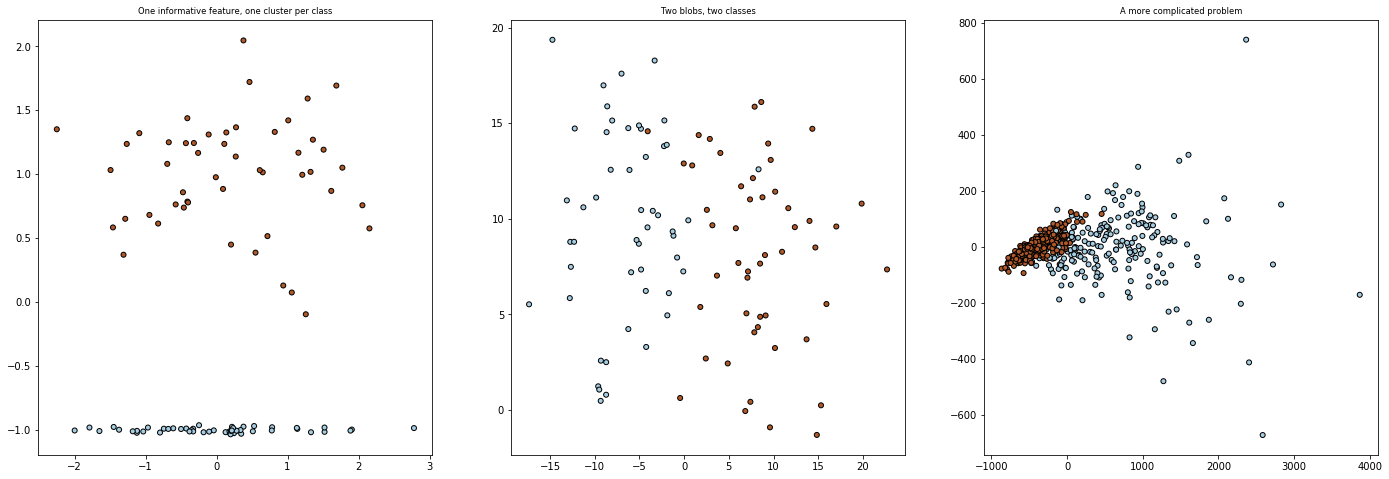

In [4]:
# Load and plot three different classification datasets
X2, Y2 = ds.make_classification(n_samples=100, n_features=2, n_redundant=0,
                                n_informative=1,
                                n_clusters_per_class=1)
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title("One informative feature, one cluster per class", fontsize='small')
ax.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

X3, Y3 = ds.make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=5)
ax = fig.add_subplot(132)
ax.set_title("Two blobs, two classes", fontsize='small')
ax.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

X4, Y4 = load_breast_cancer()
ax = fig.add_subplot(133)
ax.set_title("A more complicated problem", fontsize='small')
ax.scatter(X4[:, 0], X4[:, 1], marker='o', c=Y4,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

Previously, we have seen how sklearn can be used to fit and test a classifier on these datasets using both
decision trees and a nearest neighbors classifiers. Now, we are going to see how we can use and evaluate
support vector machine and kernel approaches

**Support Vector Machines** 
Altough Support Vector Machines are quite intuitive and easy to use, they have quite a lot of hyperparameters. One general and highly important parameter is the slack C, which defaults to 1.0 in scikit learn. The SVM in scikit-learn contains defaults for the linear, polynomial and radial basis function kernels, and has options for their specific hyperparameters. However, SVMs also accept manually constructed and precomputed kernels.

**Kernels**
Kernels can be used to transform a feature space to another, often higher dimensional feature space. When the classes are more easily separable in the new feature space, this transformation may help any classifier to perform better. Scikit learn offers a variety of kernels, which we as stated can use with any classifiers. However, as the SVM mathematically is highly suitable to be used with kernels, only the SVM contains a nice interaction with kernels.

Let's start with using some default SVMs, than experiment with some hyperparameters, and finally use some alternative kernels with SVMs, but also with other kernels.

/home/martijn/Documents/VEKTML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


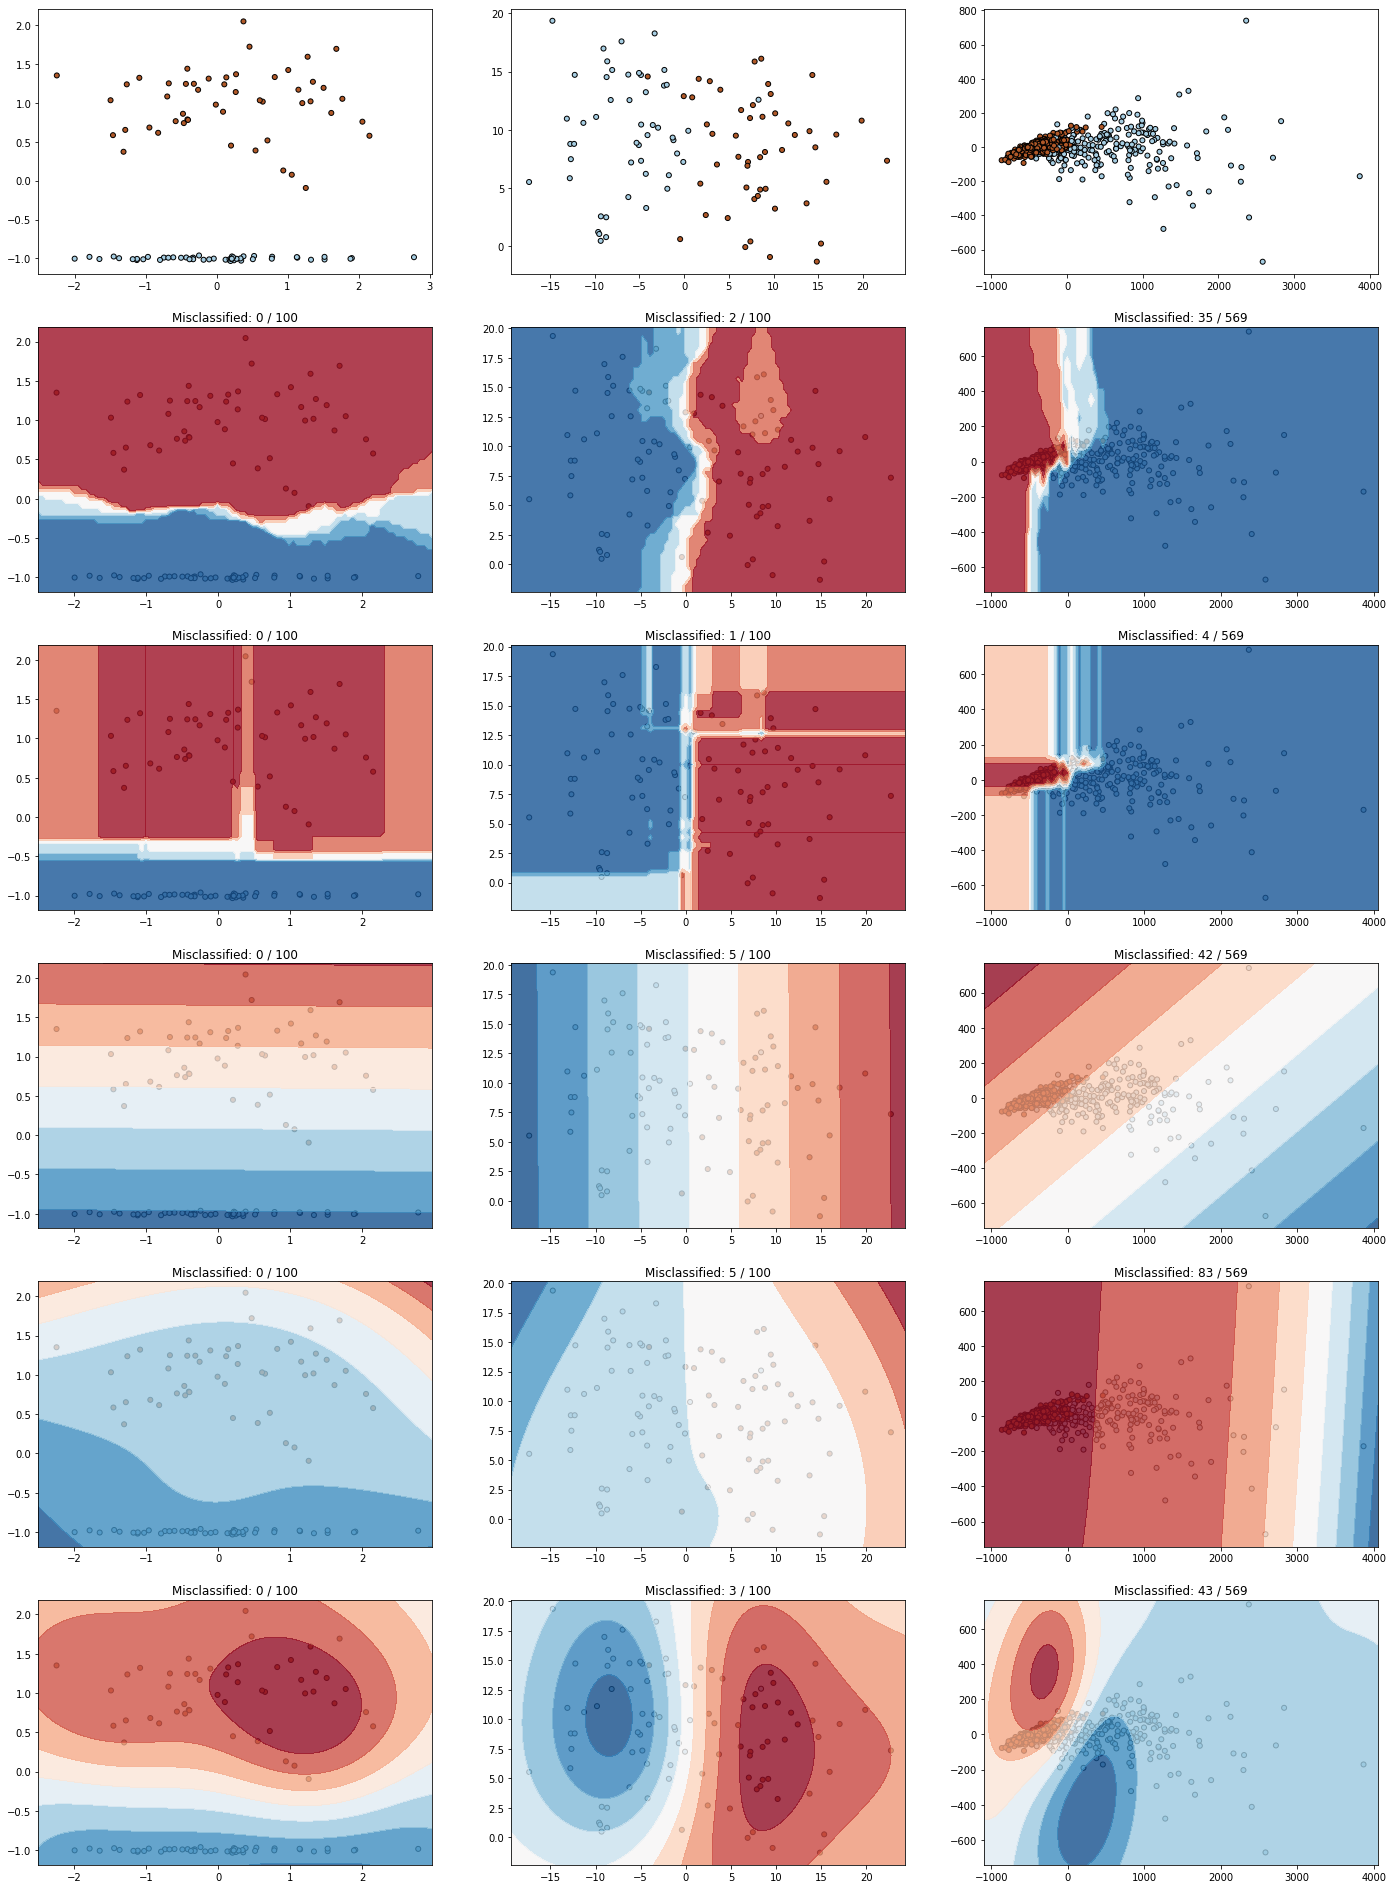

In [5]:
# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]


# Create lists of datasets to loop over
Xs = [X2, X3, X4]
Ys = [Y2, Y3, Y4]

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        clf.fit(X, Y)
        ax = fig.add_subplot(7, 3, num + 1)
        ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
        colorplot(clf, ax, X[:, 0], X[:, 1])
        y_pred = clf.predict(X)
        t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
        ax.set_title(t)
        num += 1
        
# Note: you may get a FutureWarning, which you can for now just ignore

You can immediately see that the decision boundaries created by the SVMs look very different from a Random Forest or KNN. Also, you can also easily recognize the type of kernel used in the SVM from the shapes of the decision boundaries. Can you see how?

Probably, your SVMs performed far worse than the other classifiers, except from maybe the first dataset. However, keep in mind that these classifiers are now both trained and tested on the same dataset. Which classifier would you pick to test on an external test dataset, i.e. which classifier do you think will generalize better? 

The importance of tuning your model complexity to the application will be addressed further in the next lecture.

## SVM hyperparameters
As stated, the SVM contains quite some hyperparameters. Let us for know focus on the polynomial SVM, which contains key hyperparameters:
- The degree of the kernel
- The homogeneity of the kernel, called coef0 in sklearn. What does this parameter actually do?
- The general slack parameter

Do you think it is nice to have such a large amount of hyperparemeters, or not?

Note that there are far more, check the scikit-learn documentation. Let us for now see how these parameters influence our performance.

Let us run the same experiment, but varying these hyperparameters.

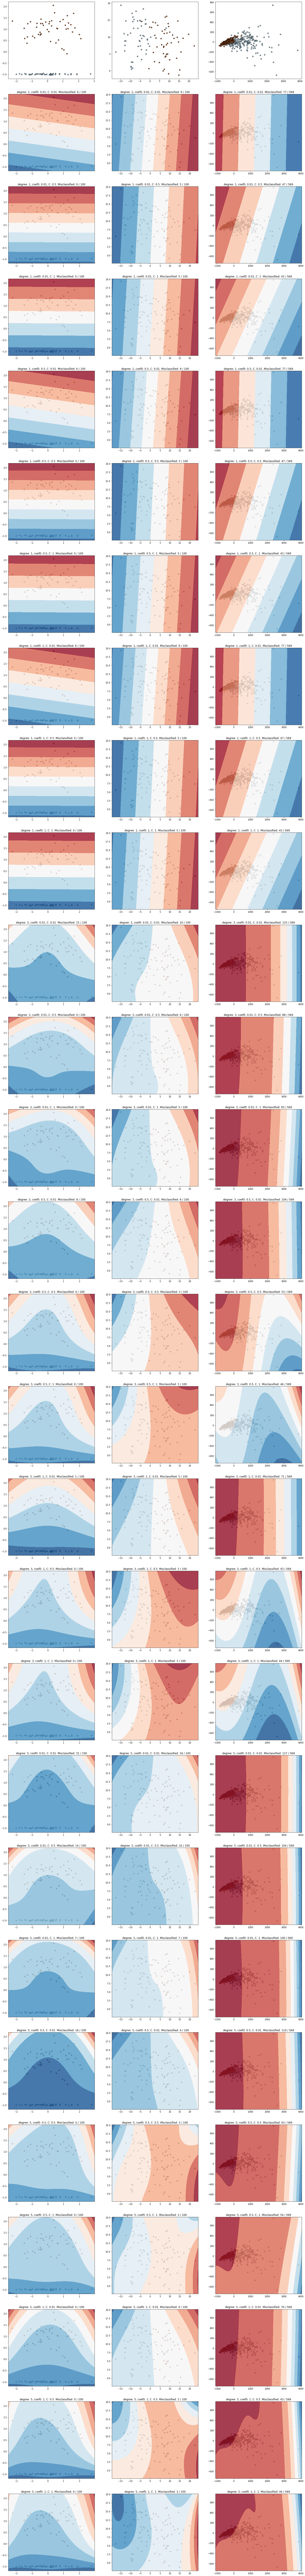

In [6]:
# Construct classifiers
degrees = [1, 3, 5]
coef0s = [0.01, 0.5, 1]
slacks = [0.01, 0.5, 1]

clsfs = list()
for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            clsfs.append(SVC(kernel='poly', degree=degree, coef0=coef0, C=slack, gamma='scale'))

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(len(clsfs) + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        clf.fit(X, Y)
        ax = fig.add_subplot(len(clsfs) + 1, 3, num + 1)
        ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
        colorplot(clf, ax, X[:, 0], X[:, 1])
        y_pred = clf.predict(X)
        t = f"degree: {clf.degree}, coef0: {clf.coef0}, C: {clf.C}. "
        t = t + ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
        ax.set_title(t)
        num += 1
        
# Note: you may get a FutureWarning, which you can for now just ignore

What do you observe:
- What is the influence of coef0, the slack, and the degree on the boundaries?
- Does giving the SVM more freedom (i.e. higher degree, higher slack) results in better results?
- Which solution would you pick to externally validate? Would you pick the same on each dataset?
- For many classifiers, the performance is actually the similar: most of your classifiers will have a perfect score on the first dataset. However, the decision boundaries are quite different. How could you determine automatically which one is best?

Again, note that the SVM has more hyperparameters and functionalities as explained here, which may be useful for the final assignment.


## Kernels
We have just seen how the SVM in scikit-learn already has some kernels implemented. However, there exist many more kernels, and kernels can be applied in combination with other estimators as well, which is what we are going to look at now.

Let us first take a closer look at the radial basis function (RBF) kernel, which is similar to a Gaussian, and was already included in the SVM. Scikit-learn offers three alternatives for using such a kernel: 1) a sampler, which transforms your feature space using such a kernel and randomly draws some feature samples from this space; 2) a kernel function, which we can use inside the SVM; or 3) precomputing the kernel

RBFSampler
gaussian_process.kernels.RBF(
also use a weird kernel, e.g. ExpSineSquared
compare with RBF SVM, RandomForest on kernel features

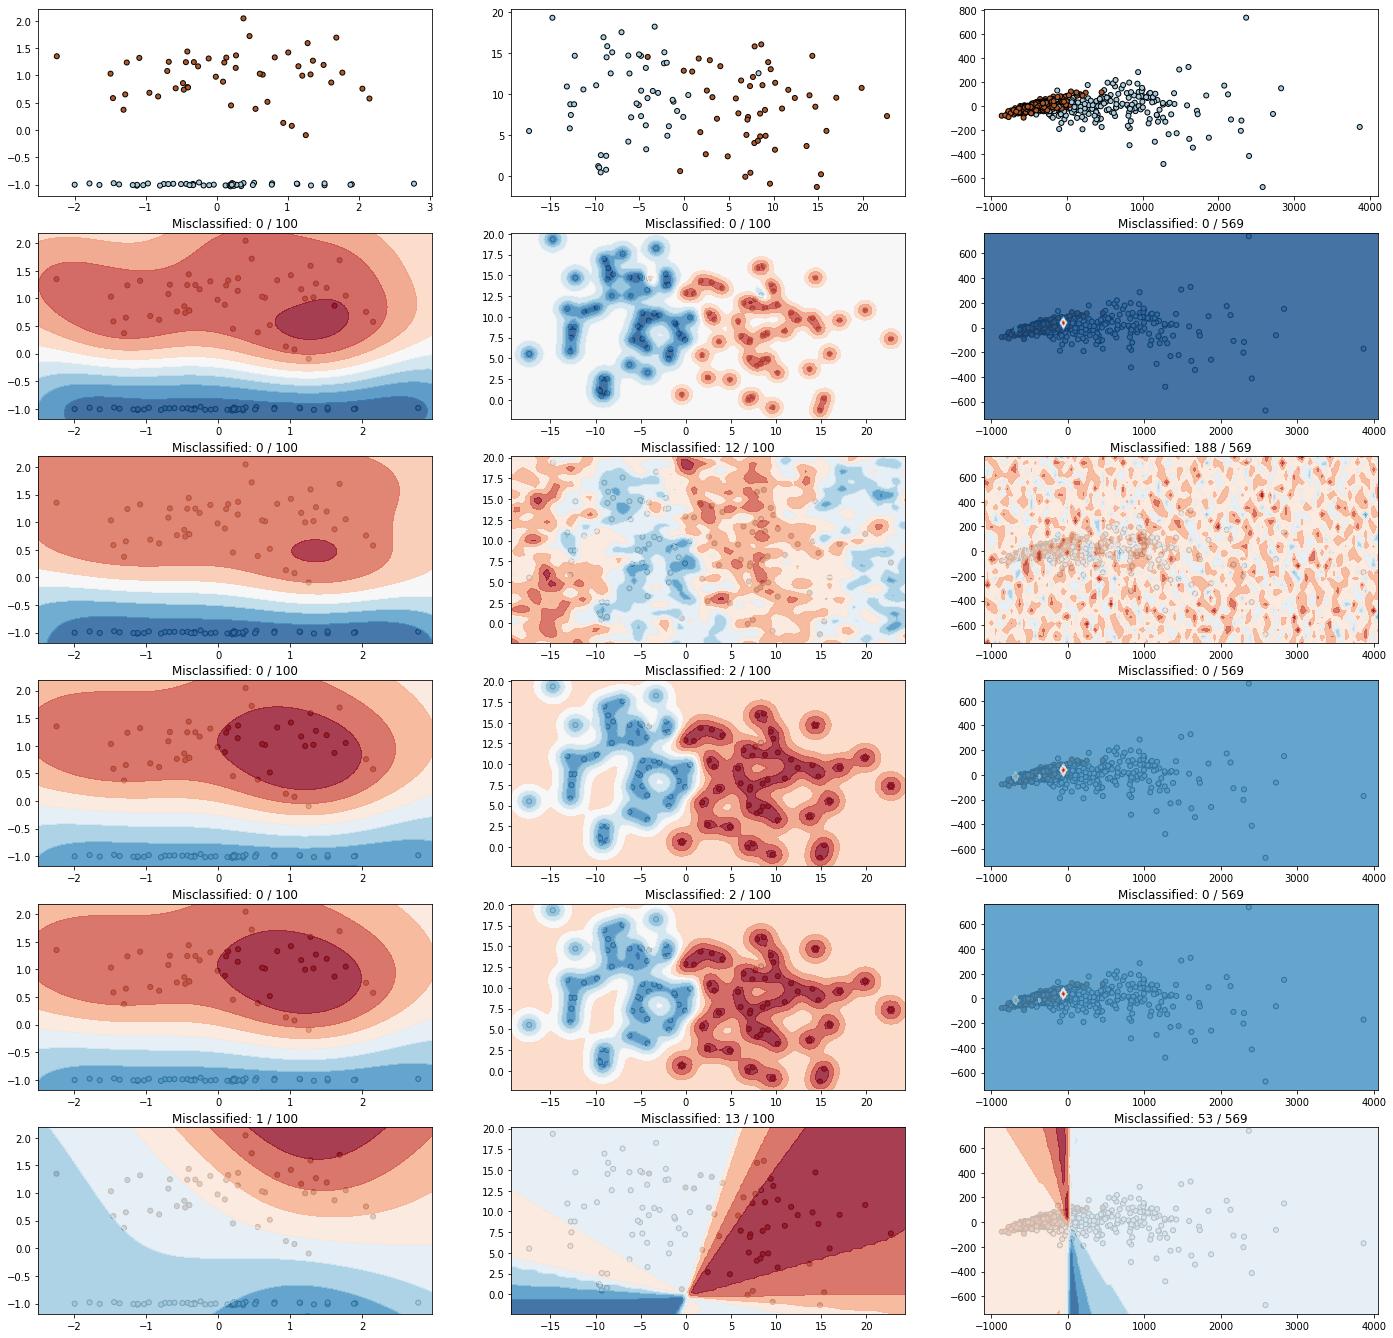

In [7]:
# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*3))
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(5 + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1
    
# Option 1: use the standard RBF kernel from the scikit-learn SVM
clf = SVC(kernel='rbf', gamma=1)
for X, Y in zip(Xs, Ys):
    clf.fit(X, Y)
    ax = fig.add_subplot(5 + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(X)
    t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
    ax.set_title(t)
    num += 1
        

# Option 2: Manually transform the feature space with an RBF kernel, sample a part of this, than apply a linear SVM
rbf_feature = RBFSampler(gamma=1, random_state=1)
clf = SVC(kernel='linear')
for X, Y in zip(Xs, Ys):
    XR = rbf_feature.fit_transform(X)
    clf.fit(XR, Y)
    ax = fig.add_subplot(5 + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1], precomputer=rbf_feature)
    y_pred = clf.predict(XR)
    t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
    ax.set_title(t)
    num += 1
    
# Option 3: supply a manually constructed kernel function to the SVM
clf = SVC(kernel=rbf_kernel)
for X, Y in zip(Xs, Ys):
    clf.fit(X, Y)
    ax = fig.add_subplot(5 + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(X)
    t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
    ax.set_title(t)
    num += 1

# Option 4: precompute the RBF kernel
clf = SVC(kernel='precomputed')
for X, Y in zip(Xs, Ys):
    rbf_kernel_computed = rbf_kernel(X)
    clf.fit(rbf_kernel_computed, Y)
    ax = fig.add_subplot(5 + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1], precomputer=rbf_kernel)
    y_pred = clf.predict(rbf_kernel_computed)
    t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
    ax.set_title(t)
    num += 1
    
# Extra: use a totally different kernel!
clf = SVC(kernel=sigmoid_kernel)
for X, Y in zip(Xs, Ys):
    clf.fit(X, Y)
    ax = fig.add_subplot(5 + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(X)
    t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
    ax.set_title(t)
    num += 1

What do you observe:
- What happens when we subsample the RBF space?
- What happens if we supply a different RBF kernel?
- What happens if we precompute the features? Hint: check the training time!
- How did the last kernel do?

## Kernel PCA